Based off of [What is torch.nn really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import model_selection, preprocessing
import torch

In [2]:
%matplotlib notebook

# Load the MNIST data

In [3]:
!head ../data/raw/mnist/train.csv

In [4]:
mnist_arr = np.loadtxt("../data/raw/mnist/train.csv", delimiter=',', skiprows=1, dtype=np.int64)

In [5]:
# raw features are between 0 and 255
mnist_arr.min(), mnist_arr.max()

(0, 255)

## Split the MNIST data into training and validation sets

In [6]:
prng = np.random.RandomState(42)
training_arr, validation_arr = model_selection.train_test_split(mnist_arr, test_size=0.20, random_state=prng)

In [7]:
training_arr.shape

(33600, 785)

In [8]:
training_target, training_features = training_arr[:, 0], training_arr[:, 1:]

In [9]:
validation_arr.shape

(8400, 785)

In [10]:
validation_target, validation_features = validation_arr[:, 0], validation_arr[:, 1:]

## Need to rescale the raw data

In [11]:
min_max_scaler = preprocessing.MinMaxScaler()
scaled_training_features = min_max_scaler.fit_transform(training_features)
scaled_validation_features = min_max_scaler.fit_transform(validation_features)

/home/pughdr/.conda/envs/pytorch-gpu-tutorial/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/pughdr/.conda/envs/pytorch-gpu-tutorial/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Check out a training sample

<IPython.core.display.Javascript object>


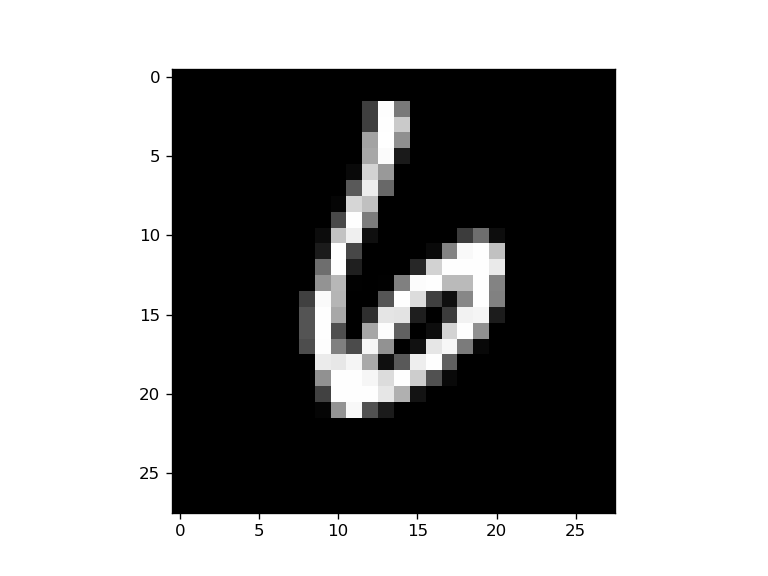

In [12]:
_, ax = plt.subplots(1,1)
_ = ax.imshow(scaled_training_features[0].reshape((28, 28)), cmap="gray")

PyTorch uses `torch.tensor` rather than `numpy.ndarray` so we need to convert data.

In [13]:
training_target = torch.tensor(training_target)
scaled_training_features = torch.tensor(scaled_training_features, dtype=torch.float32)

validation_target = torch.tensor(validation_target)
scaled_validation_features = torch.tensor(scaled_validation_features, dtype=torch.float32)

In [14]:
scaled_training_features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [15]:
scaled_training_features.max()

tensor(1.)

In [16]:
scaled_training_features.dtype

torch.float32

In [17]:
training_target

tensor([6, 5, 3,  ..., 2, 6, 0])

# Neural network from scratch

In [18]:
import math

In [19]:
number_samples, number_features = scaled_training_features.shape

# using Xavier initialization (divide weights by sqrt(number_features))
weights = torch.randn(number_features, 10) / math.sqrt(number_features)
weights.requires_grad_() # trailing underscore indicates in-place operation
bias = torch.zeros(10, requires_grad=True)

In [28]:
def _linear_transformation(X):
    return X @ weights + bias

def _log_softmax_activation(X):
    return X - X.exp().sum(-1).log().unsqueeze(-1)
    
def model(X):
    Z = _linear_transformation(X)
    return _log_softmax_activation(Z)

In [29]:
batch_size = 64
output = model(scaled_training_features[:batch_size])

In [30]:
output[1]

tensor([-2.6039, -2.7502, -2.4771, -2.2918, -1.7146, -2.5615, -2.3451, -2.0644,
        -2.1464, -2.5234], grad_fn=<SelectBackward>)

In [31]:
output.shape

torch.Size([64, 10])

In [32]:
def negative_log_likelihood(output, target):
    m, _ = output.shape
    return -output[range(m), target].mean()
    

In [33]:
negative_log_likelihood(output, training_target[:batch_size])

tensor(2.3410, grad_fn=<NegBackward>)

In [34]:
def accuracy(output, target):
    predictions = torch.argmax(output, dim=1)
    return (predictions == target).float().mean()

In [35]:
accuracy(output, training_target[:64])

tensor(0.0938)

In [36]:
number_epochs = 2
number_batches = (number_samples - 1) // batch_size + 1

learning_rate = 0.5
for epoch in range(number_epochs):
    for batch in range(number_batches):
        # forward pass
        start = batch * batch_size
        X = scaled_training_features[start:(start + batch_size)]
        y = training_target[start:(start + batch_size)]
        output = model(X)
        loss = negative_log_likelihood(output, y)
        
        # back propagation
        loss.backward()
        with torch.no_grad():
            weights -= learning_rate * weights.grad
            bias -= learning_rate * bias.grad
            weights.grad.zero_()
            bias.grad.zero_()
            

In [38]:
negative_log_likelihood(model(X), y), accuracy(model(X), y)

(tensor(0.0933, grad_fn=<NegBackward>), tensor(0.9844))

# Refactor using `torch.nn.functional`

In [39]:
import torch.nn.functional as F

In [40]:
def model(X):
    return X @ weights + bias

loss_function = F.cross_entropy

In [41]:
loss_function(model(X), y), accuracy(model(X), y)

(tensor(0.0933, grad_fn=<NllLossBackward>), tensor(0.9844))

# Refactor using `torch.nn.Module`

In [42]:
from torch import nn


class MNISTLogisticRegression(nn.Module):
    
    def __init__(self):
        super().__init__()
        self._weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self._bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, X):
        return X @ self._weights + self._bias
    


In [43]:
model = MNISTLogisticRegression()

In [44]:
loss_function(model(X), y)

tensor(2.3830, grad_fn=<NllLossBackward>)

In [45]:
def fit(model, loss_function, number_samples, number_epochs=2, batch_size=64):
    
    number_batches = (number_samples - 1) // batch_size + 1
    for epoch in range(number_epochs):
        for batch in range(number_batches):
            # forward pass
            start = batch * batch_size
            X = scaled_training_features[start:(start + batch_size)]
            y = training_target[start:(start + batch_size)]
            output = model(X)
            loss = loss_function(output, y)

            # back propagation
            loss.backward()
            with torch.no_grad():
                for parameter in model.parameters():
                    parameter -= learning_rate * parameter.grad
                model.zero_grad()


In [46]:
fit(model, loss_function, number_samples)

In [47]:
loss_function(model(X), y)

tensor(0.0937, grad_fn=<NllLossBackward>)

# Refactoring using `nn.Linear`

In [48]:
from torch import nn


class MNISTLogisticRegression(nn.Module):
    
    def __init__(self):
        super().__init__()
        self._linear_layer = nn.Linear(784, 10)
        
    def forward(self, X):
        return self._linear_layer(X)
    


In [49]:
model = MNISTLogisticRegression()

In [50]:
loss_function(model(X), y)

tensor(2.2898, grad_fn=<NllLossBackward>)

In [51]:
fit(model, loss_function, number_samples)

In [52]:
loss_function(model(X), y)

tensor(0.0923, grad_fn=<NllLossBackward>)

# Refactoring using `torch.optim`

In [53]:
from torch import optim

In [54]:
def fit(model, loss_function, optimizer, number_samples, number_epochs=2, batch_size=64):
    
    number_batches = (number_samples - 1) // batch_size + 1
    for epoch in range(number_epochs):
        for batch in range(number_batches):
            # forward pass
            start = batch * batch_size
            X = scaled_training_features[start:(start + batch_size)]
            y = training_target[start:(start + batch_size)]
            output = model(X)
            loss = loss_function(output, y)
            
            # back propagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


In [55]:
fit(model, F.cross_entropy, optim.SGD(model.parameters(), lr=0.5), number_samples)

In [56]:
F.cross_entropy(model(X), y)

tensor(0.0815, grad_fn=<NllLossBackward>)

# Refactor using `TensorDataSet`

In [57]:
from torch.utils import data

In [58]:
training_data = data.TensorDataset(scaled_training_features, training_target)

In [59]:
def fit(model, loss_function, optimizer, number_samples, number_epochs=2, batch_size=64):
    
    number_batches = (number_samples - 1) // batch_size + 1
    for epoch in range(number_epochs):
        for batch in range(number_batches):
            # forward pass
            start = batch * batch_size
            X, y = training_data[start:(start + batch_size)]
            output = model(X)
            loss = loss_function(output, y)
            
            # back propagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


In [60]:
fit(model, F.cross_entropy, optim.SGD(model.parameters(), lr=0.5), number_samples)

In [61]:
F.cross_entropy(model(X), y)

tensor(0.0763, grad_fn=<NllLossBackward>)

# Refactor using `DataLoader`

In [62]:
training_data_loader = data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

In [63]:
def fit(model, loss_function, optimizer, data_loader, number_epochs=2):
    
    for epoch in range(number_epochs):
        for X, y in data_loader:
            output = model(X)
            loss = loss_function(output, y)
            
            # back propagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


In [64]:
fit(model, F.cross_entropy, optim.SGD(model.parameters(), lr=0.5), training_data_loader)

In [65]:
F.cross_entropy(model(X), y)

tensor(0.1167, grad_fn=<NllLossBackward>)

# Adding Validation

In [66]:
validation_data = data.TensorDataset(scaled_validation_features, validation_target)
validation_data_loader = data.DataLoader(validation_data, batch_size=2*batch_size)

In [107]:
def fit(model, loss_function, optimizer, training_data_loader, validation_data_loader=None, number_epochs=2):
    
    for epoch in range(number_epochs):
        model.train()
        for X, y in training_data_loader:
            output = model(X)
            loss = loss_function(output, y)
            
            # back propagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # compute validation loss after each training epoch
        if validation_data_loader is not None:
            model.eval()
            with torch.no_grad():
                batch_losses, batch_sizes = zip(*[(loss_function(model(X), y), len(X)) for X, y in validation_data_loader])
                validation_loss = np.sum(np.multiply(batch_losses, batch_sizes)) / np.sum(batch_sizes)
            print(epoch, validation_loss)


In [68]:
fit(model, F.cross_entropy, optim.SGD(model.parameters(), lr=0.5), training_data_loader, validation_data_loader)

0 0.3094427846726917
1 0.29399465594972884


# Switching to CNN

In [69]:
class MNISTCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self._conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self._conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self._conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, X):
        X = X.view(-1, 1, 28, 28) # implicit knowledge of MNIST data shape!
        X = F.relu(self._conv1(X))
        X = F.relu(self._conv2(X))
        X = F.relu(self._conv3(X))
        X = F.avg_pool2d(X, 4)
        return X.view(-1, X.size(1))
    

In [70]:
model = MNISTCNN()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

fit(model, F.cross_entropy, optimizer, training_data_loader, validation_data_loader)

0 0.5103448293322609
1 0.35839658135459534


# Refactor using `nn.Sequential`

In [71]:
class LambdaLayer(nn.Module):
    
    def __init__(self, f):
        super().__init__()
        self._f = f
        
    def forward(self, X):
        return self._f(X)
    


In [72]:
model = nn.Sequential(
    LambdaLayer(lambda X: X.view(-1, 1, 28, 28)),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    LambdaLayer(lambda X: X.view(X.size(0), -1))
)

In [73]:
fit(model,
    F.cross_entropy,
    optim.SGD(model.parameters(), lr=0.1, momentum=0.9),
    training_data_loader,
    validation_data_loader)

0 0.5062314249220349
1 0.3074838808604649


# Wrapping DataLoader

In [74]:
class WrappedDataLoader:
    
    def __init__(self, data_loader, f):
        self._data_loader = data_loader
        self._f = f
        
    def __len__(self):
        return len(self._data_loader)
    
    def __iter__(self):
        for batch in iter(self._data_loader):
            yield self._f(*batch)


In [75]:
preprocess = lambda X, y: (X.view(-1, 1, 28, 28), y)
training_data_loader = WrappedDataLoader(training_data_loader, preprocess)
validation_data_loader = WrappedDataLoader(validation_data_loader, preprocess)

In [76]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    LambdaLayer(lambda X: X.view(X.size(0), -1))
)

In [77]:
fit(model,
    F.cross_entropy,
    optim.SGD(model.parameters(), lr=0.1, momentum=0.9),
    training_data_loader,
    validation_data_loader)

0 0.5092156639553251
1 0.2856105839638483


# Using GPU

In [78]:
torch.cuda.is_available()

True

In [79]:
preprocess = lambda X, y: (X.view(-1, 1, 28, 28).to("cuda"), y.to("cuda"))
training_data_loader = WrappedDataLoader(training_data_loader, preprocess)
validation_data_loader = WrappedDataLoader(validation_data_loader, preprocess)

In [80]:
fit(model.to("cuda"),
    F.cross_entropy,
    optim.SGD(model.parameters(), lr=0.1, momentum=0.9),
    training_data_loader,
    validation_data_loader,
    number_epochs=5)

0 tensor(0.2705, device='cuda:0')
1 tensor(0.2642, device='cuda:0')
2 tensor(0.2062, device='cuda:0')
3 tensor(0.2148, device='cuda:0')
4 tensor(0.2027, device='cuda:0')


# Submitting to Kaggle

In [86]:
import pandas as pd

## Re-train the model using the entire training set

In [112]:
training_target, training_features = mnist_arr[:, 0], mnist_arr[:, 1:]
scaled_training_features = min_max_scaler.fit_transform(training_features)
scaled_training_features_tensor = torch.tensor(scaled_training_features, dtype=torch.float32)
training_target_tensor = torch.tensor(training_target)

training_data = data.TensorDataset(scaled_training_features_tensor, training_target_tensor)
training_data_loader = data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
wrapped_training_data_loader = WrappedDataLoader(training_data_loader, preprocess)


/home/pughdr/.conda/envs/pytorch-gpu-tutorial/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [113]:
fit(model.to("cuda"),
    F.cross_entropy,
    optim.SGD(model.parameters(), lr=0.1, momentum=0.9),
    wrapped_training_data_loader,
    number_epochs=5)

In [103]:
# submission format for kaggle
!head ../data/raw/mnist/sample_submission.csv

## Use trained model to make predictions using the test data

In [114]:
testing_features = np.loadtxt("../data/raw/mnist/test.csv", delimiter=',', skiprows=1, dtype=np.int64)

In [115]:
scaled_testing_features = min_max_scaler.fit_transform(testing_features)
scaled_testing_features = torch.tensor(scaled_testing_features, dtype=torch.float32)

/home/pughdr/.conda/envs/pytorch-gpu-tutorial/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [116]:
output = model(scaled_testing_features.view(-1, 1, 28, 28).to("cuda"))
predictions = torch.argmax(output, dim=1)

In [117]:
number_predictions, = predictions.shape

In [118]:
import time

timestamp = time.strftime("%Y%m%d-%H%M%S")
df = pd.DataFrame({"ImageId": range(1, number_predictions + 1), "Label": predictions.cpu()})
df.to_csv(f"../data/kaggle-submissions/mnist/submission-{timestamp}.csv", index=False)

In [119]:
!kaggle competitions submit digit-recognizer -f ../data/kaggle-submissions/mnist/submission-20190203-145624.csv -m "My first ever Kaggle submission!"

100%|████████████████████████████████████████| 208k/208k [00:04<00:00, 51.3kB/s]
Successfully submitted to Digit Recognizer